# Konversationen im digitalen Raum: Eine Analyse der DHd 2024 auf *Mastodon*

*Dieser Beitrag ist im Rahmen meines Reisestipendiums für die DHd 2024 vom 26. Februar bis 1. März 2024 entstanden. Ich möchte mich an dieser Stelle noch einmal bei [*NFDI4Culture*](https://nfdi4culture.de/) und den Organisatoren bedanken, die mir durch dieses Stipendium die Teilnahme an der Konferenz ermöglicht haben.*

In diesem [*Jupyter Notebook*](https://jupyter.org/) wenden wir uns einem eher unkonventionellen Untersuchungsgegenstand zu: den Diskussionen innerhalb der *Digital Humanities* auf [Mastodon](https://mastodon.social/), markiert durch den Hashtag `#dhd2024`. Die Analyse zielt darauf ab, die digitale Resonanz auf die DHd 2024 zu kartografieren, indem die Dynamik der Konversationen, die führenden Stimmen, die zeitlichen Muster der Interaktion und die vorherrschenden Themen untersucht werden. Dieses Notebook sucht nach Mustern und Einblicken in die Art und Weise, wie die Community kommuniziert, welche Themen besondere Aufmerksamkeit erregen und wie sich die Diskussionskultur innerhalb eines digitalen Ökosystems wie Mastodon entwickelt. Vier Fragen sind von Interesse: Wie gut wurde diskutiert? Wer hat am meisten diskutiert? Wann wurde am meisten diskutiert? Und vor allem: Worüber wurde am meisten diskutiert?

Zuerst importieren wir einige *Python*-Bibliotheken und -Module für das spätere Web-Scraping und die Visualisierung.

In [1]:
import os
import re
import json
import requests

import pandas as pd
import matplotlib.pyplot as plt 

from tqdm import tqdm
from bs4 import BeautifulSoup
from babel.dates import format_date
from huggingface_hub import InferenceClient

Um die Exploration der Daten zu erleichtern, stellen wir alle *DataFrames* standardmäßig als interaktive Tabellen dar.

In [2]:
from itables import init_notebook_mode
init_notebook_mode(all_interactive=True)

<IPython.core.display.Javascript object>

## Abruf der *Toots* über die *Mastodon*-API

Da [X](https://twitter.com/?lang=de) mittlerweile verwaist ist und [Bluesky](https://bsky.app/) von *Digital Humanists* kaum frequentiert wird, konzentrieren wir uns auf die *Social-Media*-Aktivitäten auf [Mastodon](https://mastodon.social/). Gesammelt werden nur *Toots* mit dem Hashtag `#dhd2024`. Einige Bereinigungsschritte sind notwendig, um die *Toots* später besser verarbeiten und visualisieren zu können. Unter anderem werden alle Zeichenfolgen, die mit `<` beginnen und mit `>` enden, durch eine leere Zeichenfolge ersetzt, um HTML-Tags aus dem Inhalt der Beiträge zu entfernen.

In [3]:
def remove_html_tags(text):
    return re.sub('<.*?>', '', text)


api = 'https://mastodon.social/api/v1/timelines/tag/dhd2024'

max_id = None
results = []

with tqdm(total=len(results)) as progress:
    # Die Schleife wird solange ausgeführt, bis kein Ergebnis mehr zurückgegeben
    # wird (also eine leere Liste). Andernfalls wird `max_id` auf die ID des
    # letzten Beitrags gesetzt, um in der nächsten Iteration der Schleife die
    # nächsten Ergebnisse abrufen zu können.
    while True:
        response = requests.get(api, params = {
            'limit': 40, # begrenzt die Anzahl der Ergebnisse pro Anfrage auf 40
            'max_id': max_id, # steuert die Paginierung durch die Ergebnisse
        })
        result = response.json()
        progress.update(len(result))

        if len(result) == 0:
            break

        max_id = result[-1]['id']
        results.extend(result)
            
data_mastodon = pd.DataFrame(results)
data_mastodon['created_at'] = pd.to_datetime(data_mastodon.created_at, utc=True) + pd.Timedelta(hours=1)
data_mastodon['account_id'] = pd.json_normalize(data_mastodon.account).id
data_mastodon['account_username'] = pd.json_normalize(data_mastodon.account).username
data_mastodon['content'] = data_mastodon.content.apply(remove_html_tags)

data_mastodon.set_index('created_at', inplace=True)

data_mastodon

803it [00:01, 600.99it/s]


id in_reply_to_id  \
created_at                                                     
2024-03-26 13:12:02+00:00  112161923275002390           None   
2024-03-26 13:07:28+00:00  112161905233726709           None   
2024-03-21 08:08:51+00:00  112132419272720093           None   
2024-03-20 15:03:40+00:00  112128388153703692           None   
2024-03-20 10:01:22+00:00  112127199460626411           None   
...                                       ...            ...   
2023-03-19 14:24:35+00:00  110050166675637665           None   
2023-03-17 15:16:54+00:00  110039047759513053           None   
2023-03-17 14:47:29+00:00  110038932166643448           None   
2023-03-17 10:07:27+00:00  110037830846082363           None   
2023-03-15 11:59:12+00:00  110026945573857544           None   

                          in_reply_to_account_id  sensitive spoiler_text  \
created_at                                                                 
2024-03-26 13:12:02+00:00                   None      False                
2024-03-26 13:07:28+00:00                   None      False                
2024-03-21 08:08:51+00:00                   None      False                
2024-03-20 15:03:40+00:00                   None      False                
2024-03-20 10:01:22+00:00                   None      False                
...                                          ...        ...          ...   
2023-03-19 14:24:35+00:00                   None      False                
2023-03-17 15:16:54+00:00                   None      False                
2023-03-17 14:47:29+00:00                   None      False                
2023-03-17 10:07:27+00:00                   None      False                
2023-03-15 11:59:12+00:00                   None      False                

                          visibility language  \
created_at                                      
2024-03-26 13:12:02+00:00     public       de   
2024-03-26 13:07:28+00:00     public       de   
2024-03-21 08:08:51+00:00     public       de   
2024-03-20 15:03:40+00:00     public       en   
2024-03-20 10:01:22+00:00     public       de   
...                              ...      ...   
2023-03-19 14:24:35+00:00     public       en   
2023-03-17 15:16:54+00:00     public       en   
2023-03-17 14:47:29+00:00     public       de   
2023-03-17 10:07:27+00:00     public       en   
2023-03-15 11:59:12+00:00     public       en   

                                                                         uri  \
created_at                                                                     
2024-03-26 13:12:02+00:00  https://fedihum.org/users/DHd/statuses/1121619...   
2024-03-26 13:07:28+00:00  https://fedihum.org/users/DHd/statuses/1121619...   
2024-03-21 08:08:51+00:00  https://fedihum.org/users/RaDiHum20/statuses/1...   
2024-03-20 15:03:40+00:00  https://fedihum.org/users/sashabruns/statuses/...   
2024-03-20 10:01:22+00:00  https://fedihum.org/users/RaDiHum20/statuses/1...   
...                                                                      ...   
2023-03-19 14:24:35+00:00  https://hcommons.social/users/dh_potsdam/statu...   
2023-03-17 15:16:54+00:00  https://hcommons.social/users/dh_potsdam/statu...   
2023-03-17 14:47:29+00:00  https://openbiblio.social/users/msiemund/statu...   
2023-03-17 10:07:27+00:00  https://fedihum.org/users/arockenberger/status...   
2023-03-15 11:59:12+00:00  https://fedihum.org/users/arockenberger/status...   

                                                                         url  \
created_at                                                                     
2024-03-26 13:12:02+00:00        https://fedihum.org/@DHd/112161922887159762   
2024-03-26 13:07:28+00:00        https://fedihum.org/@DHd/112161904938272194   
2024-03-21 08:08:51+00:00  https://fedihum.org/@RaDiHum20/112132419214446019   
2024-03-20 15:03:40+00:00  https://fedihum.org/@sashabruns/11212838801266...   
2024-03-20 10:01:22+00:00  https://fedihum.org/@RaDiHum20/1121

## Statistik der *Mastodon-Toots*

### Wie gut wurde diskutiert?

Größere Diskussionen kamen bei Mastodon kaum zustande: Ein erheblicher Teil der Beiträge blieb entweder unbeantwortet oder erhielt nur eine Antwort; sequentielle Antworten, also Antworten auf bereits vorhandene Antworten, wurden bei der Auswertung nicht berücksichtigt. Eine Ausnahme bildete ein [*Toot*](https://mastodon.green/@malterehbein/111997033759484333) von Malte Rehbein mit sieben Antworten, der fragte, wer an der `#dhd2014` teilgenommen habe und plane, zur `#dhd2024` wieder nach Passau zu kommen. Erwähnenswert ist auch der [*Toot*](https://fedihum.org/@uwuttke/112020210102035413) von Ulrike Wuttke, der mit fünf Antworten ebenfalls zu den aktiveren Diskussionen zählt.

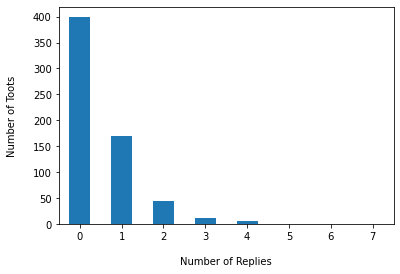

In [4]:
data_mastodon[data_mastodon.in_reply_to_id.isnull()].replies_count.value_counts().sort_index().plot(kind='bar')

plt.xlabel('\nNumber of Replies')
plt.ylabel('Number of Toots\n')
plt.xticks(rotation=0)
plt.show()

### Wer hat am meisten diskutiert?

Spitzenreiter mit den meisten *Toots* (bzw. Antworten auf *Toots*) ist nicht der Account des [Verbands der DHd](https://fedihum.org/@dhd) oder der [DHd 2024](https://fedihum.org/@dhdkonferenz) selbst, sondern [Melanie Seltmann](https://openbiblio.social/@msiemund) und das [Institut für Dokumentologie und Editorik (IDE)](https://fedihum.org/@ide). [Jürgen Hermes](https://fedihum.org/@spinfocl) schrieb besonders viele Antworten auf *Toots*.

In [5]:
# Toots nach Account, exklusive Antworten auf Toots
data_mastodon[data_mastodon.in_reply_to_id.isnull()].account_username.value_counts(normalize=True)

ide             0.053543
msiemund        0.050394
jomla           0.048819
DHd             0.040945
stefandumont    0.040945
                  ...   
ck282           0.001575
isws            0.001575
feichtimo       0.001575
geho            0.001575
schassan        0.001575
Name: account_username, Length: 109, dtype: float64

In [6]:
# Toots nach Account, inklusive Antworten auf Toots
data_mastodon.account_username.value_counts(normalize=True)

spinfocl           0.062267
msiemund           0.052304
ide                0.051059
jomla              0.038605
stefandumont       0.034869
                     ...   
ck282              0.001245
geho               0.001245
nopaque            0.001245
sibylle_soering    0.001245
schassan           0.001245
Name: account_username, Length: 116, dtype: float64

### Wann wurde am meisten diskutiert?

Einen deutlichen Peak an *Toots* mit dem Hashtag `#dhd2024` sehen wir naturgemäß in der Tagungswoche vom 26. Februar bis 1. März 2024. Interessanter als die tägliche Zählung der *Toots* ist jedoch die stündliche Zählung, insbesondere mit einem gleitenden Durchschnitt von 12 Stunden: Die hohen Spitzen weisen auf hohe Aktivitätsphasen hin, die durch kurze, intensive Diskussionen verursacht werden. Der gleitende Durchschnitt zeigt (wenig überraschend) einen relativ stabilen Trend der Tagesnutzung. Die Keynote von [Marco van Leeuwen](https://www.uu.nl/staff/MHDvanLeeuwen) wurde stark diskutiert; auch am darauffolgenden Mittwoch war jedoch eine hohe Frequenz von *Toots* zu beobachten, mit leicht abnehmender Tendenz am Donnerstag und Freitag.

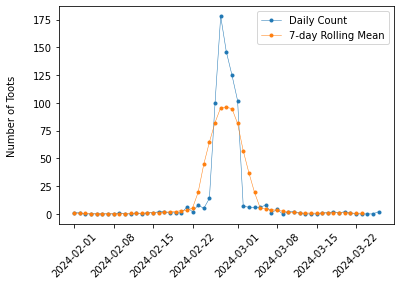

In [7]:
daily_counts = data_mastodon.resample('D').size().to_frame('number_of_toots')
daily_counts_r = daily_counts.rolling(7, center=True).mean()

start, end = '2024-02-01', '2024-03-31'

fig, ax = plt.subplots()
ax.plot(
    daily_counts.loc[start:end, 'number_of_toots'],
    marker='.',
    linestyle='-',
    linewidth=0.5,
    label='Daily Count',
)
ax.plot(
    daily_counts_r.loc[start:end, 'number_of_toots'],
    marker='.',
    linestyle='-',
    linewidth=0.5,
    label='7-day Rolling Mean',
)
ax.tick_params(axis='x', rotation=45)
ax.set_ylabel('Number of Toots\n')
ax.legend()
plt.show()

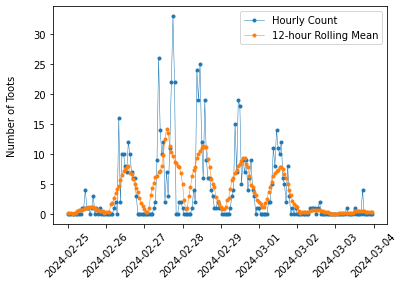

In [8]:
hourly_counts = data_mastodon.resample('h').size().to_frame('number_of_toots')
hourly_counts_r = hourly_counts.rolling(12, center=True).mean()

start, end = '2024-02-25', '2024-03-03'

fig, ax = plt.subplots()
ax.plot(
    hourly_counts.loc[start:end, 'number_of_toots'],
    marker='.',
    linestyle='-',
    linewidth=0.5,
    label='Hourly Count',
)
ax.plot(
    hourly_counts_r.loc[start:end, 'number_of_toots'],
    marker='.',
    linestyle='-',
    linewidth=0.5,
    label='12-hour Rolling Mean',
)
ax.tick_params(axis='x', rotation=45)
ax.set_ylabel('Number of Toots\n')
ax.legend()
plt.show()

### Worüber wurde am meisten diskutiert?

Die Analyse der *Toot*-Frequenzen der Keynotes (am Dienstagabend und Freitagnachmittag) ist relativ direkt, da diese die einzigen Veranstaltungen in diesem Zeitfenster waren und somit keine Abgrenzung zu anderen Veranstaltungen notwendig ist. Eine Herausforderung stellt hingegen die Auswertung der meistdiskutierten Sessions dar. Sie erfordert eine differenziertere Herangehensweise, um jeden *Toot* korrekt der inhaltlich passenden Session zuzuordnen. Wir gehen dabei wie folgt vor: Zunächst extrahieren wir mittels *Web Scraping* das Programm der DHd 2024, um die Zeitfenster und Vorträge der einzelnen Sessions zu erhalten. Anschließend verwenden wir mit [Mistral-7B-Instruct-v0.2](https://huggingface.co/mistralai/Mistral-7B-Instruct-v0.2) ein *Large Language Model* (LLM) für die eigentliche Zuordnung von *Toot* zu Session; diese Zuordnung wird nicht immer, aber wahrscheinlich in den meisten Fällen korrekt sein.

In [9]:
results = []

# Wir gehen Datum für Datum vor: Extrahiert werden Informationen zu den
# Zeitfenstern der Sessions, ihre Titel und zugehörigen Untertiteln. 
for date in pd.date_range(start='2024-02-26', end='2024-03-01'):
    date_string = format_date(date, 'EEEE-dd-MM-yyyy', locale='de_DE')
    url = 'https://dhd2024.dig-hum.de/programm-{}/'.format(date_string)
    
    soup = BeautifulSoup(requests.get(url).text)
    content = soup.select_one('.entry-content')
    
    time_slot = None # speichert das Zeitfenster für die jeweilige Session
    subtitles = [] # speichert die Vorträge der jeweiligen Session
    
    for el in content.select('*', recursive=False):
        if 'wp-block-heading' in el.get('class', []):
            if re.match(r'[0-9]{2}:[0-9]{2}', el.text):
                time_slot = el.text.strip()
            elif time_slot and el.name == 'h4':
                if subtitles:
                    results[-1].append('; '.join(subtitles))
                    subtitles = []
                    
                results.append([date, time_slot, el.text])
        elif 'wp-block-columns' in el.get('class', []):
            subtitles.append(el.select_one('strong').text)
            
    if subtitles:
        results[-1].append('; '.join(subtitles))

Auch hier sind einige Bereinigungsschritte notwendig, um die *Toots* später besser verarbeiten und zuordnen zu können.

In [10]:
data_program = pd.DataFrame(results, columns=['date', 'time', 'title', 'subtitles'])
data_program['date'] = data_program.date.astype(str)
data_program[['time_start', 'time_end']] = data_program.time.str.split('—', expand=True).apply(lambda x: x.str.strip())
data_program['time_start'] = pd.to_datetime(data_program.date + ' ' + data_program.time_start, utc=True)
data_program['time_end'] = pd.to_datetime(data_program.date + ' ' + data_program.time_end, utc=True)
data_program['subtitles'].fillna('', inplace=True)
data_program['description'] = data_program.title + ' (' + data_program.subtitles + ')'

data_program

date           time  \
0   2024-02-26  14:00 — 17:30   
1   2024-02-26  14:00 — 17:30   
2   2024-02-26  14:00 — 17:30   
3   2024-02-26  14:00 — 17:30   
4   2024-02-26  14:00 — 17:30   
5   2024-02-26  14:00 — 17:30   
6   2024-02-26  14:00 — 17:30   
7   2024-02-26  14:00 — 17:30   
8   2024-02-27  09:00 — 12:30   
9   2024-02-27  09:00 — 12:30   
10  2024-02-27  09:00 — 12:30   
11  2024-02-27  09:00 — 12:30   
12  2024-02-27  09:00 — 12:30   
13  2024-02-27  09:00 — 12:30   
14  2024-02-27  09:00 — 12:30   
15  2024-02-27  09:00 — 12:30   
16  2024-02-27  09:00 — 12:30   
17  2024-02-27  09:00 — 12:30   
18  2024-02-27  14:00 — 17:30   
19  2024-02-27  14:00 — 17:30   
20  2024-02-27  14:00 — 17:30   
21  2024-02-27  14:00 — 17:30   
22  2024-02-27  14:00 — 17:30   
23  2024-02-27  14:00 — 17:30   
24  2024-02-27  14:00 — 17:30   
25  2024-02-27  14:00 — 17:30   
26  2024-02-28  09:00 — 10:30   
27  2024-02-28  09:00 — 10:30   
28  2024-02-28  09:00 — 10:30   
29  2024-02-28  09:00 — 10:30   
30  2024-02-28  11:00 — 12:30   
31  2024-02-28  11:00 — 12:30   
32  2024-02-28  11:00 — 12:30   
33  2024-02-28  11:00 — 12:30   
34  2024-02-28  14:00 — 15:30   
35  2024-02-28  14:00 — 15:30   
36  2024-02-28  14:00 — 15:30   
37  2024-02-28  14:00 — 15:30   
38  2024-02-29  09:00 — 10:30   
39  2024-02-29  09:00 — 10:30   
40  2024-02-29  09:00 — 10:30   
41  2024-02-29  09:00 — 10:30   
42  2024-02-29  11:00 — 12:30   
43  2024-02-29  11:00 — 12:30   
44  2024-02-29  11:00 — 12:30   
45  2024-02-29  11:00 — 12:30   
46  2024-03-01  09:00 — 10:30   
47  2024-03-01  09:00 — 10:30   
48  2024-03-01  09:00 — 10:30   
49  2024-03-01  11:00 — 12:30   
50  2024-03-01  11:00 — 12:30   
51  2024-03-01  11:00 — 12:30   

                                                title  \
0   W5: How to do Theory: Reflexive Praktiken in d...   
1   W11: Evaluating Digital Humanities Methods and...   
2   W12: not opaque flow – Workflows zur Aufbereit...   
3   W14: Microblogging mit Mastodon: Fediverse, Fe...   
4                        W6: Hands-on-Workshop DNBLab   
5   W4a: Uncovering the Forgotten Bits: Perspektiv...   
6   W3a: Explorationen unbekannter Korpora mit Top...   
7   W16a: Vernetzte Forschungsdaten – wer kennt we...   
8   W2a: Der Weg zum grünen Forschungsdatenmanagem...   
9   W18: Machine Learning to Read Yesterday’s News...   
10  W4b: Uncovering the Forgotten Bits: Perspektiv...   
11              W10: BEACONe unde venis et quo vadis?   
12  W3b: Explorationen unbekannter Korpora mit Top...   
13  W13a: Videoanalyse mit der Plattform TIB-AV-A....   
14  W16b: Vernetzte Forschungsdaten – wer kennt we...   
15  W8a: Generative KI, LLMs und GPT bei digitalen...   
16  W15: Offen – frei zugänglich – für alle? Parti...   
17  W19a: Das richtige Tool für die Volltextdigita...   
18  W2b: Der Weg zum grünen Forschungsdatenmanagem...   
19  W9: Edierst Du noch oder trainierst Du schon? ...   
20  W17: Erstellung von DH Workflows im SSH Open M...   
21  W7: Producing & sparqling Open and FAIR data w...   
22  W1: Literatur im Wikiversum – Eine praktische ...   
23  W13b: Videoanalyse mit der Plattform TIB-AV-A....   
24  W8b: Generative KI, LLMs und GPT bei digitalen...   
25  W19b: Das richtige Tool für die Volltextdigita...   
26                         V1_1: Digitales Kulturerbe   
27                           V1_2: Workflows mit LLMs   
28                              Doctoral Consortium 1   
29                                            Panel 1   
30                         V2_1: Forschungsplatformen   
31                   V2_2: Digitale Musikwissenschaft   
32                              Doctoral Consortium 2   
33                                            Panel 2   
34                            V3_1: Texte und Sprache   
35                              V3_2: Multimedialität   
36                              Doctoral Consortium 3   
37                                            Panel 3   
38                              V4_1:

In [11]:
data_mastodon_subset = data_mastodon[
    (data_mastodon.index >= data_program.time_start.min())
    & (data_mastodon.index <= data_program.time_end.max())
    & data_mastodon.in_reply_to_id.isnull()
]

data_mastodon_subset

id in_reply_to_id  \
created_at                                                     
2024-03-01 12:21:18+00:00  112020165729501137           None   
2024-03-01 12:12:57+00:00  112020132922162312           None   
2024-03-01 12:10:07+00:00  112020121891004424           None   
2024-03-01 12:05:18+00:00  112020103170238826           None   
2024-03-01 12:04:13+00:00  112020098573903613           None   
...                                       ...            ...   
2024-02-26 14:24:42+00:00  111998001677294201           None   
2024-02-26 14:22:43+00:00  111997994070772914           None   
2024-02-26 14:19:32+00:00  111997981444433915           None   
2024-02-26 14:16:03+00:00  111997968212837717           None   
2024-02-26 14:10:25+00:00  111997945516284434           None   

                          in_reply_to_account_id  sensitive spoiler_text  \
created_at                                                                 
2024-03-01 12:21:18+00:00                   None      False                
2024-03-01 12:12:57+00:00                   None      False                
2024-03-01 12:10:07+00:00                   None      False                
2024-03-01 12:05:18+00:00                   None      False                
2024-03-01 12:04:13+00:00                   None      False                
...                                          ...        ...          ...   
2024-02-26 14:24:42+00:00                   None      False                
2024-02-26 14:22:43+00:00                   None      False                
2024-02-26 14:19:32+00:00                   None      False                
2024-02-26 14:16:03+00:00                   None      False                
2024-02-26 14:10:25+00:00                   None      False                

                          visibility language  \
created_at                                      
2024-03-01 12:21:18+00:00     public       de   
2024-03-01 12:12:57+00:00     public       de   
2024-03-01 12:10:07+00:00     public       en   
2024-03-01 12:05:18+00:00     public       de   
2024-03-01 12:04:13+00:00     public       de   
...                              ...      ...   
2024-02-26 14:24:42+00:00     public       en   
2024-02-26 14:22:43+00:00     public       de   
2024-02-26 14:19:32+00:00     public       en   
2024-02-26 14:16:03+00:00     public       en   
2024-02-26 14:10:25+00:00     public       de   

                                                                         uri  \
created_at                                                                     
2024-03-01 12:21:18+00:00  https://fedihum.org/users/mprell/statuses/1120...   
2024-03-01 12:12:57+00:00  https://fedihum.org/users/mprell/statuses/1120...   
2024-03-01 12:10:07+00:00  https://sigmoid.social/users/lysander07/status...   
2024-03-01 12:05:18+00:00  https://fedihum.org/users/jojoweis/statuses/11...   
2024-03-01 12:04:13+00:00  https://fedihum.org/users/Christianvater/statu...   
...                                                                      ...   
2024-02-26 14:24:42+00:00  https://mastodon.green/users/malterehbein/stat...   
2024-02-26 14:22:43+00:00  https://fedihum.org/users/ZfdG/statuses/111997...   
2024-02-26 14:19:32+00:00  https://mastodon.green/users/malterehbein/stat...   
2024-02-26 14:16:03+00:00  https://fedihum.org/users/christof/statuses/11...   
2024-02-26 14:10:25+00:00  https://openbiblio.social/users/msiemund/statu...   

                                                                         url  \
created_at                                                                     
2024-03-01 12:21:18+00:00     https://fedihum.org/@mprell/112020165671480371   
2024-03-01 12:12:57+00:00     https://fedihum.org/@mprell/112020132855495051   
2024-03-01 12:10:07+00:00  https://sigmoid.social/@lysander07/11202012165...   
2024-03-01 12:05:18+00:00   https://fedihum.org/@jojoweis/112020102761912902   
2024-03-01 12:04:13+00:00  https://fedihum.org/@Christianvater

Wir verwenden die Informationen aus dem Programm der DHd 2024, um sogenannte *Prompts* zu generieren, die an das LLM weitergeleitet werden. Für jeden Beitrag wird geprüft, welche Sessions zeitlich mit dem Veröffentlichungsdatum des *Toots* übereinstimmen. Ziel ist es, nur die Sessions zu berücksichtigen, die zum Zeitpunkt des jeweiligen *Toots* stattgefunden haben (und damit das *Context Window* des LLMs nicht zu überschreiten). Ein *Prompt* sieht zum Beispiel so aus; Zeilenumbrüche und -einrückungen dienen nur der besseren Lesbarkeit:

`Ordne den folgenden Beitrag der inhaltlich passenden Session zu. Gebe nur den Namen der Session zurück oder None, wenn keine Session zutrifft. Keine Erklärungen.
Beitrag: "Mit 5kg sind Sie dabei!" @toroe hat keine Mühen gespart, um uns hier echte, materialisierte historische Digitalität mit nach Passau zu bringen. #DHd2024
Mögliche Sessions: [
    'V3_1: Texte und Sprache (Applied Text as Graph (ATAG); Cross-Linguistic Data Formats (CLDF): D’où Venons Nous? Que Sommes Nous? Où Allons Nous?; Closing the Gap in Non-Latin-Script Data: Pragmatic Approaches for Increasing Awareness)',
    'V3_2: Multimedialität (Katalog und Textkorpus zu Diskettenmagazinen der 1980er und 1990er; Computational Game Studies? Drei Annäherungsperspektiven; My Body is a Cage: Human Pose Estimation und Retrieval in kunsthistorischen Inventaren)',
    'Doctoral Consortium 3 (Paradigmen einer digitalen Rezeptionswissenschaft; Processing Qualitative Interview Data – Development of a Software Platform to Support Open Data in the Humanities; „Mutter, Vater, Kind“. Ressourcenarme automatische Metaphernverarbeitung für religionswissenschaftliche Fragestellungen)',
    'Panel 3 (Bedeutung in Zeiten großer Sprachmodelle)'
]`

In [12]:
if os.path.exists('data/session-mapping-dhd2024.csv'):
    data_session_mapping = pd.read_csv('data/session-mapping-dhd2024.csv', index_col=0)
else:
    prompt_scheme = (
        '[INST]',
        'Ordne den folgenden Beitrag der inhaltlich passenden Session zu. Gebe nur den Namen der Session zurück oder `None`, wenn keine Session zutrifft. Keine Erklärungen.',
        'Beitrag: {post}',
        'Mögliche Sessions: {sessions}',
        '[\INST]',
    )
    templates = (
        r'Panel [1-9]',
        r'Doctoral Consortium [1-9]',
        r'V[1-9]_[1-9]',
        r'W[1-9][0-9]?',
        r'None',
    )

    # Das Rate Limit kann erhöht werden, wenn ein Account mit Hugging Face erstellt
    # und ein dort generierter Token in InferenceClient() übergeben wird.
    client = InferenceClient()

    results = []

    for _, row in tqdm(data_mastodon_subset.iterrows()):
        data_program_subset = data_program[
            (data_program.time_start <= row.name)
            & (data_program.time_end >= row.name)
        ]

        if not data_program_subset.empty:
            response = client.post(
                json = {
                    'inputs': ' '.join(prompt_scheme).format(
                        post = row['content'],
                        sessions = data_program_subset.description.tolist(),
                    )
                },
                model = 'mistralai/Mistral-7B-Instruct-v0.2',
            )
            result = json.loads(response)[0]['generated_text']

            # Nicht immer werden keine Erklärungen zurückgegeben, daher muss der
            # Output minimal mit Regex-Templates bereinigt werden.
            session_name = result.split('[\INST]')[-1].strip()
            session_name = re.sub(r'(\\n|\\)', '', session_name)

            for template in templates:
                if re.match(template, session_name):
                    session_name = re.findall(template, session_name)[0]
                    break

            results.append([row['id'], session_name])

    data_session_mapping = pd.DataFrame(results, columns=['id', 'title'])
    data_session_mapping.to_csv('data/session-mapping-dhd2024.csv')

Mit 45 *Toots* konnten die meisten dem Workshop `W8` (*Generative KI, LLMs und GPT bei digitalen Editionen*) zugeordnet werden, der ganztägig am 27. Februar stattfand. Auch ansonsten prägt der Themenkomplex insbesondere um LLMs die Diskussion: So fand die Session `V1_2` (*Workflows mit LLMs*) mit 9 *Toots* durchaus stärkere Resonanz. Ganz anders positionieren sich die Sessions mit den zweit- und dritthäufigsten *Toots*: Praktisch ging es in `V2_1` (*Forschungsplatformen*; 20 *Toots*) zu, eher theoriegetrieben in `V5_3` (*DH-Theorie und Geschichte*; 17 *Toots*).

In [13]:
data_session_mapping.title.value_counts().sort_index()

Doctoral Consortium 1     2
Doctoral Consortium 2     4
Doctoral Consortium 4     1
None                     16
Panel 1                   9
Panel 2                   1
Panel 3                   2
Panel 4                   1
Panel 6                   4
Panel 7                   1
V1_1                      7
V1_2                      9
V2_1                     20
V2_2                      1
V3_1                      3
V3_2                     14
V4_1                      7
V4_2                      6
V5_1                      8
V5_2                      2
V5_3                     17
V6_1                      8
V7_1                      3
V7_2                     10
W1                        2
W10                       1
W11                       2
W12                       4
W13                       7
W14                      13
W15                      12
W18                       1
W2                        1
W3                        5
W4                        1
W5                        2
W6                        1
W7                        1
W8                       45
W9                        2
Name: title, dtype: int64